In [1]:
#import the module
from pipeline import spec_pipeline

import matplotlib.pyplot as plt
%matplotlib inline

#import bokeh to enable interactive plots
from bokeh.plotting import figure
from bokeh.io import output_notebook, push_notebook, show

output_notebook()

#import yaml to read in the parameter file
import yaml

#imports to use RECTE
import os
from astropy.table import QTable
import astropy.units as u
import numpy as np
from astropy.io import fits
from astropy.table import Table, join


Loading BokehJS ...

In [2]:
with open("corot1_batch_file.yaml", "r") as stream:
    bparamfile = yaml.safe_load(stream)
    
bparamfile

{'procFiles': ['/home/kglidic/Software/tser_tools/tshirt/corot1_visit1/*_flt.fits',
  '/home/kglidic/Software/tser_tools/tshirt/corot1_visit2/*_flt.fits',
  '/home/kglidic/Software/tser_tools/tshirt/corot1_visit3/*_flt.fits',
  '/home/kglidic/Software/tser_tools/tshirt/corot1_visit4/*_flt.fits'],
 'excludeList': ['ibh717giq_flt.fits',
  'ibh719gkq_flt.fits',
  'ibh720i5q_flt.fits',
  'ibh721olq_flt.fits'],
 'srcName': 'CoRoT-1',
 'srcNameShort': 'corot1',
 'nightName': ['visit1', 'visit2', 'visit3', 'visit4'],
 'dispDirection': 'x',
 'starPositions': [74],
 'refPhotCentering': None,
 'bkgSubDirections': ['Y'],
 'bkgRegionsX': [[None, None]],
 'bkgOrderX': 0,
 'bkgRegionsY': [[[9, 32], [41, 49], [92, 122]],
  [[0, 14], [25, 32], [39, 56], [100, 121]],
  [[9, 32], [39, 46], [92, 122]],
  [[9, 32], [39, 46], [92, 122]]],
 'bkgOrderY': 1,
 'apWidth': 30.0,
 'dispPixels': [0, 128],
 'numSplineKnots': 6,
 'splineSpecFitOrder': 2,
 'sigForBadPx': 300,
 'jdRef': 2457551,
 'timingMethod': None,

In [3]:
bspec = spec_pipeline.batch_spec(batchFile='corot1_batch_file.yaml')

In [5]:
bspec

Working on showStarChoices for batch CoRoT-1 corot1_visit1 


FileNotFoundError: [Errno 2] No such file or directory: '/home/kglidic/Software/tser_tools/tshirt/corot1_visit1/ibh717iuq_flt.fits'

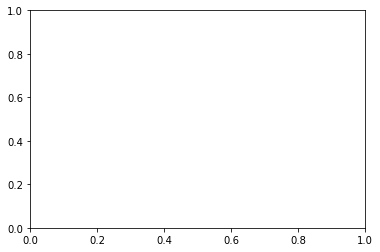

In [4]:
bspec.batch_run('showStarChoices',vmax=1000,showPlot=True)

In [6]:
bspec.batch_run('do_extraction',useMultiprocessing=True)

Working on do_extraction for batch CoRoT-1 corot1_visit1 
On 0 of 98On 75 of 98
On 15 of 98
On 30 of 98
On 45 of 98
On 60 of 98

On 90 of 98


FileNotFoundError: [Errno 2] No such file or directory: '/home/kglidic/Software/tser_tools/tshirt/corot1_visit1/ibh717gmq_flt.fits'

Working on plot_one_spec for batch CoRoT-1 corot1_visit1 


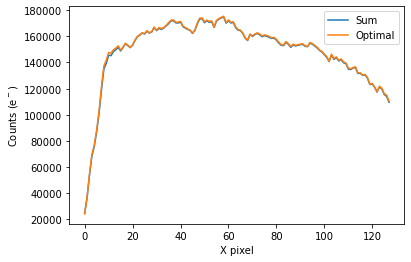

Working on plot_one_spec for batch CoRoT-1 corot1_visit2 


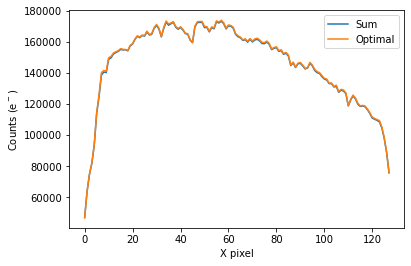

Working on plot_one_spec for batch CoRoT-1 corot1_visit3 


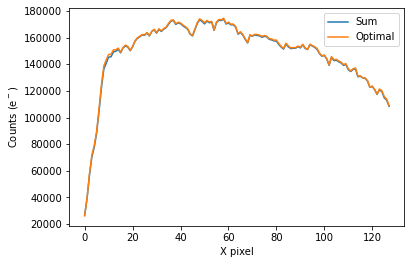

Working on plot_one_spec for batch CoRoT-1 corot1_visit4 


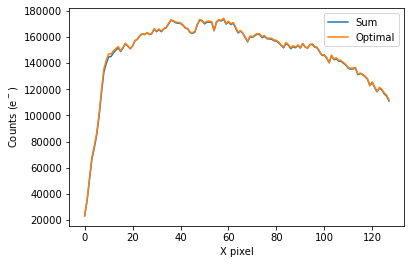

In [11]:
bspec.batch_run('plot_one_spec')

In [12]:
bspec.batch_run('plot_wavebin_series', nbins=1, interactive=True)

Working on plot_wavebin_series for batch CoRoT-1 corot1_visit1 


Working on plot_wavebin_series for batch CoRoT-1 corot1_visit2 


Working on plot_wavebin_series for batch CoRoT-1 corot1_visit3 


Working on plot_wavebin_series for batch CoRoT-1 corot1_visit4 


In [13]:
result = bspec.batch_run('get_wavebin_series',nbins=10, recalculate=True)

Working on get_wavebin_series for batch CoRoT-1 corot1_visit1 
Working on get_wavebin_series for batch CoRoT-1 corot1_visit2 
Working on get_wavebin_series for batch CoRoT-1 corot1_visit3 
Working on get_wavebin_series for batch CoRoT-1 corot1_visit4 


In [92]:
cube3d = np.zeros([len(corot1),head['NAXIS2'],head['NAXIS1']])
cube3d.shape

(98, 128, 128)

In [94]:
for ind,oneFile in enumerate(corot1['file names']):
    cube3d[ind,:,:] = fits.getdata("/home/kglidic/Software/tser_tools/tshirt/corot1_visit1/{}".format(oneFile),extname='SCI')

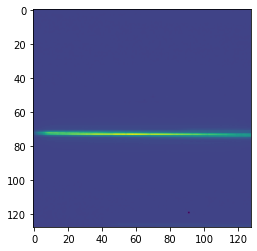

In [98]:
plt.imshow(cube3d[15,:,:])

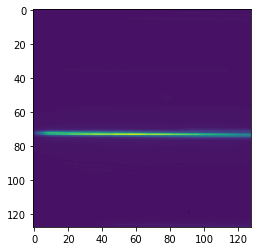

In [101]:
medianImage = np.median(cube3d,axis=0)
plt.imshow(medianImage)


In [103]:
outHDU = fits.PrimaryHDU(medianImage,head)
outHDU.writeto('median_image.fits')

In [89]:
from astropy.io import fits
head = fits.getheader('/home/kglidic/Software/tser_tools/tshirt/corot1_visit1/ibh717gjq_flt.fits',extname='SCI')
head

XTENSION= 'IMAGE   '           / IMAGE extension                                
BITPIX  =                  -32                                                  
NAXIS   =                    2                                                  
NAXIS1  =                  128                                                  
NAXIS2  =                  128                                                  
PCOUNT  =                    0 / required keyword; must = 0                     
GCOUNT  =                    1 / required keyword; must = 1                     
ORIGIN  = 'HSTIO/CFITSIO March 2010'                                            
DATE    = '2016-09-15' / date this file was written (yyyy-mm-dd)                
INHERIT =                    T / inherit the primary header                     
EXTNAME = 'SCI     '           / extension name                                 
EXTVER  =                    1 / extension version number                       
ROOTNAME= 'ibh717gjq        

In [80]:
#! /usr/bin/env python
"""calculate RECTE model using a a template grism Image
"""
from __future__ import division, absolute_import
from __future__ import print_function
import numpy as np
import itertools

import matplotlib.pyplot as plt


def RECTE(
        cRates,
        tExp,
        exptime=100.651947,
        trap_pop_s=0,
        trap_pop_f=0,
        dTrap_s=0,
        dTrap_f=0,
        dt0=0,
        lost=0,
        mode='staring'
):
    """Hubble Space Telescope ramp effet model

    Parameters:
    cRates -- intrinsic count rate of each exposures, unit e/s
    tExp -- start time of every exposures
    expTime -- (default 180 seconds) exposure time of the time series
    trap_pop -- (default 0) number of occupied traps at the beginning of the observations
    dTrap -- (default [0])number of extra trap added in the gap
    between two orbits
    dt0 -- (default 0) possible exposures before very beginning, e.g.,
    possible guiding adjustment
    lost -- (default 0, no lost) proportion of trapped electrons that are not eventually detected
    (mode) -- (default scanning, scanning or staring, or others), for scanning mode
      observation , the pixel no longer receive photons during the overhead
      time, in staring mode, the pixel keps receiving elctrons
    """
    nTrap_s = 2192  # = 1525.38  # 1320.0
    eta_trap_s = 0.02075  # = 0.013318  # 0.01311
    tau_trap_s = 1.63e4  # = 1.63e4
    nTrap_f = 225.7  # = 162.38
    eta_trap_f = 0.0116  # = 0.008407
    tau_trap_f = 3344  # = 281.463
    # nTrap_s = 1525.38  # 1320.0
    # eta_trap_s = 0.013318  # 0.01311
    # tau_trap_s = 1.63e4
    # nTrap_f = 162.38
    # eta_trap_f = 0.008407
    # tau_trap_f = 281.463

    try:
        dTrap_f = itertools.cycle(dTrap_f)
        dTrap_s = itertools.cycle(dTrap_s)
        dt0 = itertools.cycle(dt0)
    except TypeError:
        dTrap_f = itertools.cycle([dTrap_f])
        dTrap_s = itertools.cycle([dTrap_s])
        dt0 = itertools.cycle([dt0])
    obsCounts = np.zeros(len(tExp))
    trap_pop_s = min(trap_pop_s, nTrap_s)
    trap_pop_f = min(trap_pop_f, nTrap_f)
    dEsList = np.zeros(len(tExp))
    dEfList = np.zeros(len(tExp))
    dt0_i = next(dt0)
    f0 = cRates[0]
    c1_s = eta_trap_s * f0 / nTrap_s + 1 / tau_trap_s  # a key factor
    c1_f = eta_trap_f * f0 / nTrap_f + 1 / tau_trap_f
    dE0_s = (eta_trap_s * f0 / c1_s - trap_pop_s) * (1 - np.exp(-c1_s * dt0_i))
    dE0_f = (eta_trap_f * f0 / c1_f - trap_pop_f) * (1 - np.exp(-c1_f * dt0_i))
    dE0_s = min(trap_pop_s + dE0_s, nTrap_s) - trap_pop_s
    dE0_f = min(trap_pop_f + dE0_f, nTrap_f) - trap_pop_f
    trap_pop_s = min(trap_pop_s + dE0_s, nTrap_s)
    trap_pop_f = min(trap_pop_f + dE0_f, nTrap_f)
    for i in range(len(tExp)):
        try:
            dt = tExp[i+1] - tExp[i]
        except IndexError:
            dt = exptime
        f_i = cRates[i]
        c1_s = eta_trap_s * f_i / nTrap_s + 1 / tau_trap_s  # a key factor
        c1_f = eta_trap_f * f_i / nTrap_f + 1 / tau_trap_f
        # number of trapped electron during one exposure
        dE1_s = (eta_trap_s * f_i / c1_s - trap_pop_s) * (1 - np.exp(-c1_s * exptime))
        dE1_f = (eta_trap_f * f_i / c1_f - trap_pop_f) * (1 - np.exp(-c1_f * exptime))
        dE1_s = min(trap_pop_s + dE1_s, nTrap_s) - trap_pop_s
        dE1_f = min(trap_pop_f + dE1_f, nTrap_f) - trap_pop_f
        trap_pop_s = min(trap_pop_s + dE1_s, nTrap_s)
        trap_pop_f = min(trap_pop_f + dE1_f, nTrap_f)
        obsCounts[i] = f_i * exptime - dE1_s - dE1_f
        if dt < 5 * exptime:  # whether next exposure is in next batch of exposures
            # same orbits
            if mode == 'scanning':
                # scanning mode, no incoming flux between exposures
                dE2_s = - trap_pop_s * (1 - np.exp(-(dt - exptime)/tau_trap_s))
                dE2_f = - trap_pop_f * (1 - np.exp(-(dt - exptime)/tau_trap_f))
                dEsList[i] = dE1_s + dE2_s
                dEfList[i] = dE1_f + dE2_f
            elif mode == 'staring':
                # for staring mode, there is flux between exposures
                dE2_s = (eta_trap_s * f_i / c1_s - trap_pop_s) * (1 - np.exp(-c1_s * (dt - exptime)))
                dE2_f = (eta_trap_f * f_i / c1_f - trap_pop_f) * (1 - np.exp(-c1_f * (dt - exptime)))
            else:
                # others, same as scanning
                dE2_s = - trap_pop_s * (1 - np.exp(-(dt - exptime)/tau_trap_s))
                dE2_f = - trap_pop_f * (1 - np.exp(-(dt - exptime)/tau_trap_f))
            trap_pop_s = min(trap_pop_s + dE2_s, nTrap_s)
            trap_pop_f = min(trap_pop_f + dE2_f, nTrap_f)
        elif dt < 1200:
            trap_pop_s = min(trap_pop_s * np.exp(-(dt-exptime)/tau_trap_s), nTrap_s)
            trap_pop_f = min(trap_pop_f * np.exp(-(dt-exptime)/tau_trap_f), nTrap_f)
        else:
            # switch orbit
            dt0_i = next(dt0)
            trap_pop_s = min(trap_pop_s * np.exp(-(dt-exptime-dt0_i)/tau_trap_s) + next(dTrap_s), nTrap_s)
            trap_pop_f = min(trap_pop_f * np.exp(-(dt-exptime-dt0_i)/tau_trap_f) + next(dTrap_f), nTrap_f)
            f_i = cRates[i + 1]
            c1_s = eta_trap_s * f_i / nTrap_s + 1 / tau_trap_s  # a key factor
            c1_f = eta_trap_f * f_i / nTrap_f + 1 / tau_trap_f
            dE3_s = (eta_trap_s * f_i / c1_s - trap_pop_s) * (1 - np.exp(-c1_s * dt0_i))
            dE3_f = (eta_trap_f * f_i / c1_f - trap_pop_f) * (1 - np.exp(-c1_f * dt0_i))
            dE3_s = min(trap_pop_s + dE3_s, nTrap_s) - trap_pop_s
            dE3_f = min(trap_pop_f + dE3_f, nTrap_f) - trap_pop_f
            trap_pop_s = min(trap_pop_s + dE3_s, nTrap_s)
            trap_pop_f = min(trap_pop_f + dE3_f, nTrap_f)
        trap_pop_s = max(trap_pop_s, 0)
        trap_pop_f = max(trap_pop_f, 0)

    return obsCounts


def RECTEMulti(template,
                 variability,
                 tExp,
                 exptime,
                 trap_pop_s=0,
                 trap_pop_f=0,
                 dTrap_s=0,
                 dTrap_f=0,
                 dt0=0,
                 mode='staring'):
    """loop through every pixel in the template
    calculate for 6 orbit
    return
    model light curves

    template -- a template image of the input sereis
    variablities -- normalized model light curves
    tExp -- starting times of each exposure of the time resolved observations
    trap_pop_s -- (default=0)number of initially occupied traps -- slow poplulation
    trap_pop_f -- number of initially occupied traps -- fast poplulation
    dTrap_s -- (default=0, can be either number or list) number of extra
        trapped charge carriers added in the middle of two orbits
        -- slow population. If it is a number, it assumes that all
        the extra added trap charge carriers are the same
    dTrap_f -- (default=0, can be either number or list) number of extra
         trapped charge carriers added in the middle of two orbits
        -- fast population. If it is a number, it assumes that all
        the extra added trap charge carriers are the same
    """
    specShape = template.shape
    outSpec = np.zeros((specShape[0], len(tExp)))
    for i in range(specShape[0]):
        outSpec[i, :] = RECTE(
            variability * template[i],
            tExp,
            exptime,
            trap_pop_s,
            trap_pop_f,
            dTrap_s=dTrap_s,
            dTrap_f=dTrap_f,
            dt0=dt0,
            lost=0,
            mode=mode)
    return np.sum(outSpec, axis=(0))

In [83]:
tExp

array([0.0e+00, 1.0e-09, 2.0e-09, 3.0e-09, 4.0e-09, 5.0e-09, 6.0e-09,
       7.0e-09, 8.0e-09, 9.0e-09, 1.0e-08, 1.1e-08, 1.2e-08, 1.3e-08,
       1.4e-08, 1.5e-08, 1.6e-08, 1.7e-08, 1.8e-08, 1.9e-08, 2.0e-08,
       2.1e-08, 2.2e-08, 2.3e-08, 2.4e-08, 2.5e-08, 2.6e-08, 2.7e-08,
       2.8e-08, 2.9e-08, 3.0e-08, 3.1e-08, 3.2e-08, 3.3e-08, 3.4e-08,
       3.5e-08, 3.6e-08, 3.7e-08, 3.8e-08, 3.9e-08, 4.0e-08, 4.1e-08,
       4.2e-08, 4.3e-08, 4.4e-08, 4.5e-08, 4.6e-08, 4.7e-08, 4.8e-08,
       4.9e-08, 5.0e-08, 5.1e-08, 5.2e-08, 5.3e-08, 5.4e-08, 5.5e-08,
       5.6e-08, 5.7e-08, 5.8e-08, 5.9e-08, 6.0e-08, 6.1e-08, 6.2e-08,
       6.3e-08, 6.4e-08, 6.5e-08, 6.6e-08, 6.7e-08, 6.8e-08, 6.9e-08,
       7.0e-08, 7.1e-08, 7.2e-08, 7.3e-08, 7.4e-08, 7.5e-08, 7.6e-08,
       7.7e-08, 7.8e-08, 7.9e-08, 8.0e-08, 8.1e-08, 8.2e-08, 8.3e-08,
       8.4e-08, 8.5e-08, 8.6e-08, 8.7e-08, 8.8e-08, 8.9e-08, 9.0e-08,
       9.1e-08, 9.2e-08, 9.3e-08, 9.4e-08, 9.5e-08, 9.6e-08, 9.7e-08],
      dtype=float32

In [106]:
df = pd.DataFrame(result[0][0]['Time'])
corot1_visit1_files = os.listdir('/home/kglidic/Software/tser_tools/tshirt/corot1_visit1/')
#remove the direct image from this array
corot1_visit1_files.remove('ibh717giq_flt.fits')
df1 =pd.DataFrame(corot1_visit1_files,columns = ['orbit'])


TypeError: list indices must be integers or slices, not str

In [76]:
expTime=np.full((98, 1), 100.651947, dtype=np.float64)
df2 = pd.DataFrame(expTime,columns = ['Exp Time'])
Filter = np.full((98,1), 'G141')
df3 = pd.DataFrame(Filter,columns = ['Filter'])
orbit1 = np.full((23,1), 0, dtype=np.float64)
orbit2 = np.full((25,1), 1, dtype=np.float64)
orbit3 = np.full((25,1),2,dtype=np.float64)
orbit4 = np.full((25,1),3,dtype=np.float64)
orbits_visit1 = (orbit1,orbit2,orbit3,orbit4)
orbits_visit1 = np.concatenate(orbits_visit1)
df4 = pd.DataFrame(orbits_visit1,columns = ['orbit'])

In [77]:
data = [df,df1,df2,df3,df4]
corot1= pd.concat(data,axis=1)
corot1.to_csv('corot1EXAMPLERECTE.csv')
corot1

,Time,file names,Exp Time,Filter,orbit
0,2.455950e+06,ibh717gjq_flt.fits,100.651947,G141,0.0
1,2.455950e+06,ibh717gkq_flt.fits,100.651947,G141,0.0
2,2.455950e+06,ibh717glq_flt.fits,100.651947,G141,0.0
3,2.455950e+06,ibh717gmq_flt.fits,100.651947,G141,0.0
4,2.455950e+06,ibh717gnq_flt.fits,100.651947,G141,0.0
...,...,...,...,...,...
93,2.455951e+06,ibh717klq_flt.fits,100.651947,G141,3.0
94,2.455951e+06,ibh717kmq_flt.fits,100.651947,G141,3.0
95,2.455951e+06,ibh717knq_flt.fits,100.651947,G141,3.0
96,2.455951e+06,ibh717koq_flt.fits,100.651947,G141,3.0


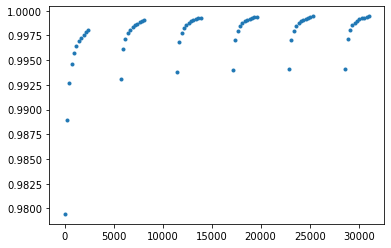

In [84]:
if __name__ == '__main__':
    import pandas as pd
    from astropy.io import fits
    import pickle
    info = pd.read_csv(
        'corot1EXAMPLERECTE.csv',
        parse_dates=True,
        index_col='Datetime')
    info['Time'] = np.float32(info.index - info.index.values[0]) / 1e9
    grismInfo = info[info['Filter'] == 'G141']
    exptime = grismInfo['Exp Time'].values[0]
    tExp = grismInfo['Time'].values
    tExp = tExp - tExp[0]
    # cRates = np.ones(len(LC)) * LC.mean() * 1.002
    cRates = np.ones(len(tExp))
    variability = cRates / cRates.mean()
    fig = plt.figure()
    ax = fig.add_subplot(111)
    im = fits.getdata('./MedianImage.fits')
    bbox = [5, 181, 174, 196]  # define the bounding box of the area of interest
    xList = np.arange(bbox[0], bbox[1])
    ramps = np.zeros((len(xList), len(tExp)))
    dTrap_fList = [0]
    dTrap_sList = [0]
    dtList = [0]
    full_well = 8e4
    for i, x in enumerate(xList):
        template = im[bbox[2]:bbox[3], x]
        for j, flux in enumerate(template):
            if flux * exptime > full_well:
                template[j] = full_well / exptime

        obs = RECTEMulti(template, variability, tExp, exptime,
                         dTrap_f=dTrap_fList,
                         dTrap_s=dTrap_sList,
                         trap_pop_f=0,
                         trap_pop_s=0,
                         dt0=dtList,
                         mode='staring')
        obs = obs / exptime / np.nansum(template)
        # ax.plot(tExp, obs, '.', color='0.8', ms=1)
        ramps[i, :] = obs
    ax.plot(tExp, ramps[30, :], '.')
    plt.show()